In [1]:
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import datetime as dt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
file_path = './data.csv'  
df = pd.read_csv(file_path)

def tidy_data(row):
    
    ########################################################
    ## Pick the level of item detail we group things into ##
    ########################################################
    
    parts = [row['SUB Category2'], row['SUB Category'], row['Category']]
    parts = [row['SUB Category'], row['Category']]
    parts = [row['Category']]
    
    non_default_parts = list(dict.fromkeys([str(part).lower() for part in parts if pd.notna(part) and part.lower() != 'default']))
    return ' '.join(non_default_parts)

df['Item'] = df.apply(tidy_data, axis=1)

all_items = df['Item'].dropna() 
unique_items = all_items.unique()

df_grouped = df.groupby('OrderHeaderNumber').agg({'Item': list}).reset_index()
df_grouped = df_grouped.rename(columns={'Item': 'Products'})
df_grouped['Size'] = df_grouped['Products'].apply(len)
df_grouped

,OrderHeaderNumber,Products,Size
0,103008,[tops],1
1,103010,"[trousers, trousers, trousers, trousers, trous...",9
2,103011,"[underwear, socks, tops, tops, sweats]",5
3,103012,"[skirts, trousers, skirts, skirts, trousers, s...",7
4,103014,[jeans],1
...,...,...,...
113027,IN0285148,[shirts],1
113028,IN0285149,"[shirts, knitwear, knitwear, knitwear]",4
113029,IN0285150,"[sweats, tops, shirts]",3
113030,IN0285151,"[tops, knitwear, tops, trousers, tops]",5


In [3]:
data = list(df_grouped["Products"])

te = TransactionEncoder()
te_data = te.fit(data).transform(data)
df = pd.DataFrame(te_data,columns=te.columns_).astype(bool)
df

,accessories,bags,blazers,dresses,hats,jeans,knitwear,outerwear,shirts,shoes,shorts,skirts,socks,sunglasses,sweats,tops,trousers,underwear
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113027,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
113028,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
113029,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False
113030,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False


In [4]:
# Apriori
freq_items = apriori(df, min_support = 0.1, use_colnames = True, verbose = 1)
freq_items.sort_values("support", ascending = False)

Processing 6 combinations | Sampling itemset size 32


,support,itemsets
3,0.527187,(tops)
4,0.308541,(trousers)
2,0.261997,(shirts)
1,0.221902,(knitwear)
0,0.197077,(jeans)
9,0.181993,"(tops, trousers)"
7,0.171341,"(shirts, tops)"
5,0.139925,"(tops, knitwear)"
8,0.130193,"(shirts, trousers)"
10,0.118913,"(shirts, tops, trousers)"


In [5]:
# Association Rules & Info
df_ar = association_rules(freq_items, metric = "confidence", min_threshold = 0.5)
df_ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(knitwear),(tops),0.221902,0.527187,0.139925,0.630572,1.196106,0.022941,1.279851,0.210711
1,(shirts),(tops),0.261997,0.527187,0.171341,0.653981,1.240511,0.033220,1.366437,0.262710
2,(trousers),(tops),0.308541,0.527187,0.181993,0.589849,1.118862,0.019334,1.152779,0.153638
3,"(shirts, tops)",(trousers),0.171341,0.308541,0.118913,0.694016,2.249347,0.066048,2.259785,0.670271
4,"(shirts, trousers)",(tops),0.130193,0.527187,0.118913,0.913360,1.732515,0.050277,5.457189,0.486090
5,"(tops, trousers)",(shirts),0.181993,0.261997,0.118913,0.653396,2.493909,0.071232,2.129238,0.732295


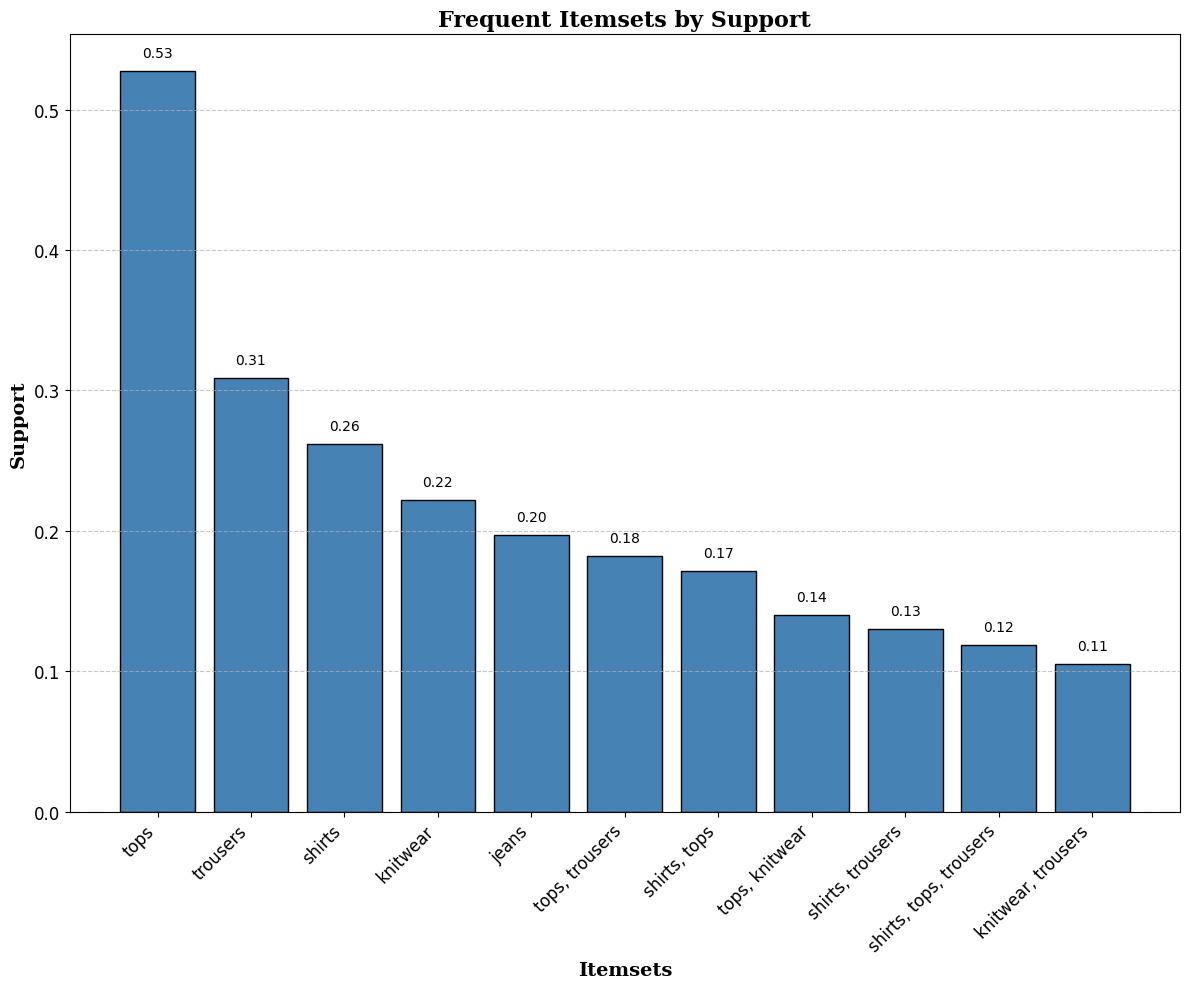

In [6]:
# Sort by support for visualization
freq_items_sorted = freq_items.sort_values("support", ascending=False)
freq_items_sorted['itemsets_cleaned'] = freq_items_sorted['itemsets'].apply(lambda x: ', '.join(list(x)))


# Bar Chart with cleaned itemsets
plt.figure(figsize=(12, 10))
plt.bar(freq_items_sorted['itemsets_cleaned'], freq_items_sorted['support'], color='steelblue', edgecolor='black')
plt.title('Frequent Itemsets by Support', fontsize=16, fontweight='bold', fontfamily='serif')
plt.xlabel('Itemsets', fontsize=14, fontweight='bold', fontfamily='serif')
plt.ylabel('Support', fontsize=14, fontweight='bold', fontfamily='serif')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add bar annotations
for index, value in enumerate(freq_items_sorted['support']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

plt.savefig('graph3.png', format='png', dpi=300)
plt.show()